# HW08 - Instrumental Variables (due November 23rd)

In this homework you will practice with running IV regressions with python. You will investigate once more the effect of schooling on earnings, but this time the instrument for education you will use is college proximity to individuals houses (reference paper by [Card, 1993](https://davidcard.berkeley.edu/papers/geo_var_schooling.pdf)).

More in detail, there are two instruments that can be exploited in this context. Both are binary variables taking value 1 if either a 2-years or 4-years college is present in the area where the individual lives.

In [40]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

from linearmodels.iv import IV2SLS
from statsmodels.iolib.summary2 import summary_col
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None

df = pd.read_stata('http://www.stata.com/data/jwooldridge/eacsap/card.dta')
pd.read_stata('http://www.stata.com/data/jwooldridge/eacsap/card.dta', iterator=True).variable_labels()

{'id': '',
 'nearc2': '=1 if near 2 yr college, 1966',
 'nearc4': '=1 if near 4 yr college, 1966',
 'educ': 'years of schooling, 1976',
 'age': 'in years',
 'fatheduc': "father's schooling",
 'motheduc': "mother's schooling",
 'weight': 'NLS sampling weight, 1976',
 'momdad14': '=1 if live with mom, dad at 14',
 'sinmom14': '=1 if with single mom at 14',
 'step14': '=1 if with step parent at 14',
 'reg661': 'regional dummy, 1966',
 'reg662': '',
 'reg663': '',
 'reg664': '',
 'reg665': '',
 'reg666': '',
 'reg667': '',
 'reg668': '',
 'reg669': '',
 'south66': '=1 if in south in 1966',
 'black': '=1 if black',
 'smsa': '=1 in in SMSA, 1976',
 'south': '=1 if in south, 1976',
 'smsa66': '=1 if in SMSA, 1966',
 'wage': 'hourly wage in cents, 1976',
 'enroll': '=1 if enrolled in school, 1976',
 'kww': 'knowledge world of work score',
 'iq': 'IQ score',
 'married': '=1 if married, 1976',
 'libcrd14': '=1 if lib. card in home at 14',
 'exper': 'age - educ - 6',
 'lwage': 'log(wage)',
 'expe

In [41]:
df.head()

,id,nearc2,nearc4,educ,age,fatheduc,motheduc,weight,momdad14,sinmom14,...,smsa66,wage,enroll,kww,iq,married,libcrd14,exper,lwage,expersq
0,2,0,0,7,29,NaN,NaN,158413.0,1,0,...,1,548,0,15.0,NaN,1.0,0.0,16,6.306275,256
1,3,0,0,12,27,8.0,8.0,380166.0,1,0,...,1,481,0,35.0,93.0,1.0,1.0,9,6.175867,81
2,4,0,0,12,34,14.0,12.0,367470.0,1,0,...,1,721,0,42.0,103.0,1.0,1.0,16,6.580639,256
3,5,1,1,11,27,11.0,12.0,380166.0,1,0,...,1,250,0,25.0,88.0,1.0,1.0,10,5.521461,100
4,6,1,1,12,34,8.0,7.0,367470.0,1,0,...,1,729,0,34.0,108.0,1.0,0.0,16,6.591674,256


### OLS

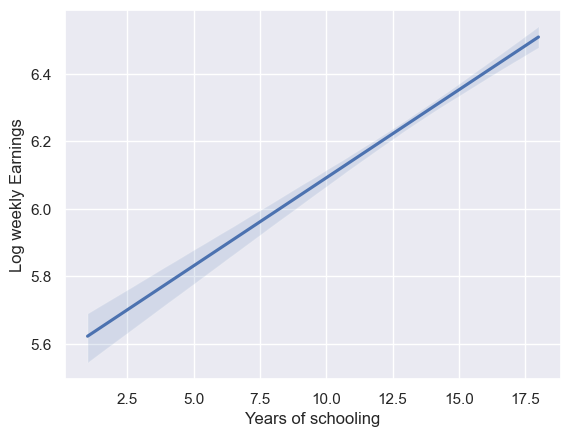

In [42]:
##plot log wages against education
sns.set_theme()

plot = sns.regplot(data=df, y='lwage', x='educ', scatter=False, ci=95)
plot.set(ylabel='Log weekly Earnings', xlabel='Years of schooling')
plt.show()

In [43]:
df.head()

,id,nearc2,nearc4,educ,age,fatheduc,motheduc,weight,momdad14,sinmom14,...,smsa66,wage,enroll,kww,iq,married,libcrd14,exper,lwage,expersq
0,2,0,0,7,29,NaN,NaN,158413.0,1,0,...,1,548,0,15.0,NaN,1.0,0.0,16,6.306275,256
1,3,0,0,12,27,8.0,8.0,380166.0,1,0,...,1,481,0,35.0,93.0,1.0,1.0,9,6.175867,81
2,4,0,0,12,34,14.0,12.0,367470.0,1,0,...,1,721,0,42.0,103.0,1.0,1.0,16,6.580639,256
3,5,1,1,11,27,11.0,12.0,380166.0,1,0,...,1,250,0,25.0,88.0,1.0,1.0,10,5.521461,100
4,6,1,1,12,34,8.0,7.0,367470.0,1,0,...,1,729,0,34.0,108.0,1.0,0.0,16,6.591674,256


In [44]:
##Regress log wages (lwage) against education and include controls, use robust standard errors.

covariates = ['fatheduc', 'motheduc', 'libcrd14', 'iq', 'black', 'south', 'smsa']
df = df.dropna(subset=['lwage', 'educ']+covariates)

x = sm.add_constant(df[['educ'] + covariates])
y = df['lwage']

ols = sm.OLS(y, x).fit(cov_type='HC1')
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lwage   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     22.17
Date:                Tue, 22 Nov 2022   Prob (F-statistic):           2.60e-32
Time:                        15:44:46   Log-Likelihood:                -799.87
No. Observations:                1616   AIC:                             1618.
Df Residuals:                    1607   BIC:                             1666.
Df Model:                           8                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7344      0.093     61.936      0.000       5.553       5.916
educ           0.0292      0.005      5.341      0.000       0.018       0.040
fatheduc      -0.0073      0.004     -1.849      0.064      -0.015       0.000
motheduc       0.0073      0.005      1.568      0.117      -0.002       0.016
libcrd14      -0.0103      0.024     -0.433      0.665      -0.057       0.036
iq             0.0012      0.001      1.288      0.198      -0.001       0.003
black         -0.1464      0.036     -4.014      0.000      -0.218      -0.075
south         -0.0873      0.022     -3.931      0.000      -0.131      -0.044
smsa           0.1639      0.023      7.184      0.000       0.119       0.209
==============================================================================
Omnibus:                       35.308   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.199
Skew:                          -0.284   Prob(JB):                     4.16e-10
Kurtosis:                       3.565   Cond. No.                         918.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

**What are other possible confunders?**

Discipline or effort: more ambitious individuals might both study longer and work harder at their job, and therefore get higher wages - not because of more education, but because they put in more effort.

### 2SLS

You will use only on proximity to a 4-years college ($nearc4$) as instrument. 

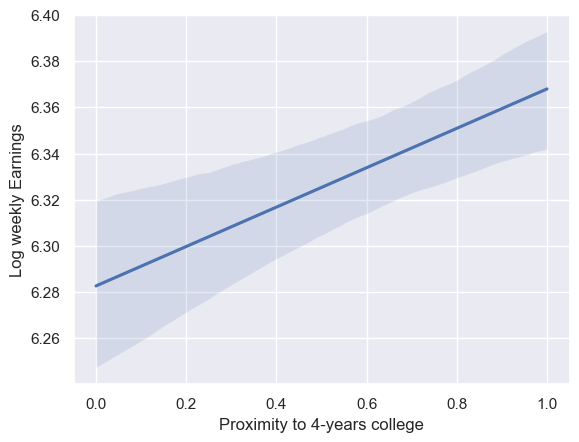

In [45]:
##plot log wages against nearc4

plot = sns.regplot(data=df, y='lwage', x='nearc4', scatter=False, ci=95)
plot.set(ylabel='Log weekly Earnings', xlabel='Proximity to 4-years college')
plt.show()

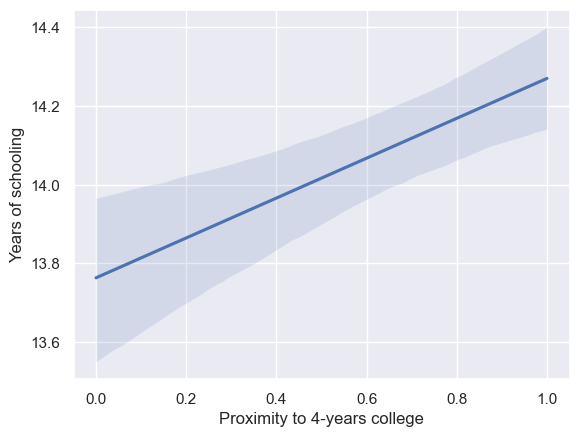

In [46]:
##plot education against nearc4

plot = sns.regplot(data=df, y='educ', x='nearc4', scatter=False, ci=95)
plot.set(ylabel='Years of schooling', xlabel='Proximity to 4-years college')
plt.show()

**If you run an IV regression of log wages on education, using college proximity as an instrument for education, what would you expect the sign of the coefficient on education to be? Why?**

I'd expect a positive effect of (instrumented) education on wages, because I think that college proximity has a positive effect on enrollment to college and this again has a positive effect on wages.

In [47]:
##run a regression of education on nearc4, adding the controls you selected before and using robust standard errors

x = sm.add_constant(df[['nearc4'] + covariates])
y = df['educ']

fs = sm.OLS(y, x).fit(cov_type='HC1')
fs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   educ   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     131.1
Date:                Tue, 22 Nov 2022   Prob (F-statistic):          2.92e-169
Time:                        15:44:47   Log-Likelihood:                -3275.8
No. Observations:                1616   AIC:                             6570.
Df Residuals:                    1607   BIC:                             6618.
Df Model:                           8                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2130      0.342     12.319      0.000       3.543       4.883
nearc4         0.2263      0.107      2.111      0.035       0.016       0.436
fatheduc       0.1231      0.018      6.710      0.000       0.087       0.159
motheduc       0.0974      0.021      4.605      0.000       0.056       0.139
libcrd14       0.4663      0.119      3.908      0.000       0.232       0.700
iq             0.0650      0.003     18.671      0.000       0.058       0.072
black          0.7830      0.179      4.383      0.000       0.433       1.133
south          0.3142      0.101      3.114      0.002       0.116       0.512
smsa           0.0973      0.113      0.864      0.387      -0.123       0.318
==============================================================================
Omnibus:                       33.462   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.343
Skew:                           0.257   Prob(JB):                     7.01e-07
Kurtosis:                       2.604   Cond. No.                         884.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [48]:
##predict education from the previous regression
df['educhat'] = fs.predict()
df[['educ', 'educhat']].head()

,educ,educhat
1,12,12.587944
2,12,14.366582
3,11,13.248280
4,12,13.225784
5,12,12.807005


In [49]:
##run a regression of log wages on education and controls using robust standard errors

x = sm.add_constant(df[['educhat']+covariates])
y = df['lwage']

twosls = sm.OLS(y, x).fit(cov_type='HC1')
twosls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lwage   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     18.37
Date:                Tue, 22 Nov 2022   Prob (F-statistic):           1.54e-26
Time:                        15:44:47   Log-Likelihood:                -814.37
No. Observations:                1616   AIC:                             1647.
Df Residuals:                    1607   BIC:                             1695.
Df Model:                           8                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6134      0.441     12.739      0.000       4.750       6.477
educhat        0.0573      0.100      0.574      0.566      -0.138       0.253
fatheduc      -0.0108      0.013     -0.828      0.408      -0.036       0.015
motheduc       0.0046      0.011      0.428      0.669      -0.016       0.026
libcrd14      -0.0239      0.054     -0.441      0.659      -0.130       0.082
iq            -0.0007      0.007     -0.101      0.919      -0.013       0.012
black         -0.1687      0.089     -1.902      0.057      -0.343       0.005
south         -0.0953      0.036     -2.625      0.009      -0.166      -0.024
smsa           0.1593      0.028      5.646      0.000       0.104       0.215
==============================================================================
Omnibus:                       34.796   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.449
Skew:                          -0.259   Prob(JB):                     1.35e-10
Kurtosis:                       3.638   Cond. No.                     5.10e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 5.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [50]:
##compare the 2sls and ols estimates 
print(summary_col([ols, twosls], float_format='%0.3f',  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))}, regressor_order=['educ', 'educhat']))


               lwage I lwage II
-------------------------------
educ           0.029           
               (0.005)         
educhat                0.057   
                       (0.100) 
black          -0.146  -0.169  
               (0.036) (0.089) 
const          5.734   5.613   
               (0.093) (0.441) 
fatheduc       -0.007  -0.011  
               (0.004) (0.013) 
iq             0.001   -0.001  
               (0.001) (0.007) 
libcrd14       -0.010  -0.024  
               (0.024) (0.054) 
motheduc       0.007   0.005   
               (0.005) (0.011) 
smsa           0.164   0.159   
               (0.023) (0.028) 
south          -0.087  -0.095  
               (0.022) (0.036) 
R-squared      0.100   0.084   
R-squared Adj. 0.096   0.079   
N              1616    1616    
Standard errors in parentheses.


**What do you think the difference in the estimates is due to?**

In the first regression (ols), education is endogenous, so part of its effect goes through the other covariates (f.ex. smsa). In the iv-regression, the effect of education is exogenous, the only variation in education that is used, is the part that is explained by proximity to a 4-year college.

### IV analysis

In [51]:
##use IV2sls to run the regression of log wages on education. using college proximity as an instrument for education
##add the same controls as 

exog = sm.add_constant(df[covariates])
iv2sls = IV2SLS(dependent = df.lwage, exog = exog, endog = df.educ, instruments = df.nearc4).fit(cov_type='robust')

print(iv2sls)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                  lwage   R-squared:                      0.0847
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0802
No. Observations:                1616   F-statistic:                    145.64
Date:                Tue, Nov 22 2022   P-value (F-stat)                0.0000
Time:                        15:44:48   Distribution:                  chi2(8)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          5.6134     0.4422     12.694     0.0000      4.7467      6.4801
fatheduc      -0.0108     0.0131    -0.8270     0.40